In [196]:
#Get names dataset:
names = open('names.txt', 'r').read().splitlines()

b = {}
for n in names:
    #Add staring and ending special characters
    n = ["<S>"] + list(n) + ["<E>"]
    for ch1, ch2 in zip (n, n[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1
sorted(b.items(), key = lambda kv: -kv[1])


[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [197]:
import torch
a = torch.zeros((3, 5), dtype = torch.int32) #2D tensor (works like array here) with 3 rows and 5 columns initialized to 0
a[1, 3] = 1 #Postion row 1 and column 3 - Value changed to 1
a


tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [198]:
N = torch.zeros ((27, 27), dtype=torch.int32) #28 by 28 tensor (26 alphabet characters + 1 special start/end characters) - Array stores counts for bigram model

#Convert characters to numbers
chars = sorted(list(set (''.join(names)))) #Converts whole names into a single string containing all the names. Set on this gives all characters possible
stoi = {s:i+1 for i,s in enumerate(chars)} #Eneumerate gives a iterator over number and character (1, a)...
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [199]:
for n in names:
    #Add staring and ending special characters
    n = ["."] + list(n) + ["."]
    for ch1, ch2 in zip (n, n[1:]):
        i1 = stoi[ch1]
        i2 = stoi[ch2]
        N[i1, i2] += 1

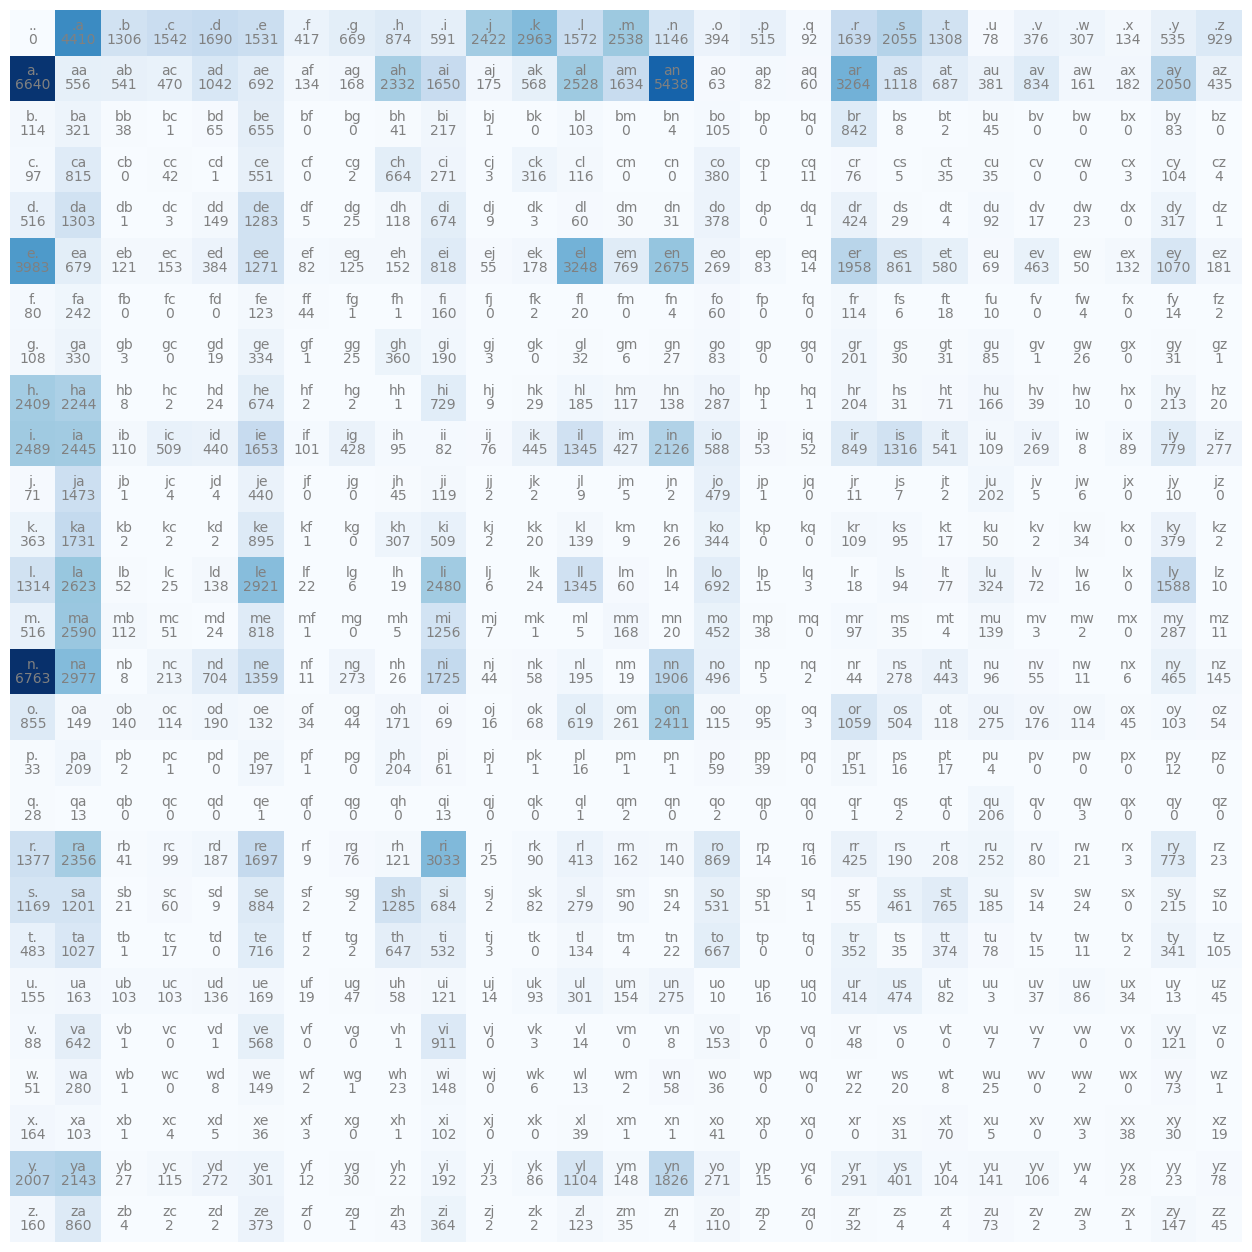

In [200]:
itos = {i:s for s, i in stoi.items()}

#Visualization of array
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues') # imshow: function that displays a 2D array as an image (matrix of pixel values)
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');


In [201]:
#Create probability distrivution
p = N[0].float() #First row as floats
p = p/p.sum() #Normalize
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [202]:
g = torch.Generator().manual_seed(2147483647) # Create a seeded random number generator for reproducibility
index = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # Generate sample
itos[index]

'c'

In [203]:
#Normalized probabilites of Tensor N
P = (N+1).float() #Model smoothing: N+1 ensures no 0s in P
P /= P.sum(dim=1, keepdim=True) #Sum along columns so for each row sum the value of that row (if dim = 0 then its sum across columns).
# keep the dimension of the summed axis as size 1 (shape 27, 1 instead of 27) #CHeck broadcasting semantics that checks if operations between tensors are allowed (47:00 in video)

In [204]:
g = torch.Generator().manual_seed(2147483647)

for i in range (20):  
    out = []
    index = 0 #Starting character
    while True:
        p = P[index] #Get row corresponding to current character
        index = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() #Sample next character
        out.append(itos[index])
        if index == 0: #If next character is ending character end sample
            break
    print (''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
ka.
emimmsade.
enkaviyny.
ftlspihinivenvorhlasu.
dsor.
br.
jol.
pen.
aisan.
ja.


In [205]:
log_likelihood = 0.0
count = 0
for n in names:
    #Add staring and ending special characters
    n = ["."] + list(n) + ["."]
    for ch1, ch2 in zip (n, n[1:]):
        i1 = stoi[ch1]
        i2 = stoi[ch2] 
        prob = P[i1, i2]
        logprob = torch.log(prob) #Better estimation of likelihood instead of multiplying all the probabilities (gives very small number)
        # Good prob close to 1 gives logprob near 0 and as prob gets worse logprob gets more negative
        log_likelihood += logprob
        count += 1
        print (f'{ch1}{ch2}: {prob: .4f} {logprob: .4f}')

print (f'{log_likelihood=}')
nll = -log_likelihood #Since loss functions are lower when good performance, the negative log likelihood follows this convention
print (f'{nll=}')
print (f'{nll/count}')

.e:  0.0478 -3.0410
em:  0.0377 -3.2793
mm:  0.0253 -3.6753
ma:  0.3885 -0.9454
a.:  0.1958 -1.6305
.o:  0.0123 -4.3965
ol:  0.0779 -2.5526
li:  0.1774 -1.7293
iv:  0.0152 -4.1845
vi:  0.3508 -1.0476
ia:  0.1380 -1.9807
a.:  0.1958 -1.6305
.a:  0.1376 -1.9835
av:  0.0246 -3.7041
va:  0.2473 -1.3971
a.:  0.1958 -1.6305
.i:  0.0185 -3.9919
is:  0.0743 -2.5998
sa:  0.1478 -1.9119
ab:  0.0160 -4.1363
be:  0.2455 -1.4044
el:  0.1589 -1.8396
ll:  0.0962 -2.3408
la:  0.1876 -1.6733
a.:  0.1958 -1.6305
.s:  0.0641 -2.7468
so:  0.0654 -2.7270
op:  0.0121 -4.4180
ph:  0.1947 -1.6364
hi:  0.0955 -2.3485
ia:  0.1380 -1.9807
a.:  0.1958 -1.6305
.c:  0.0481 -3.0339
ch:  0.1869 -1.6774
ha:  0.2937 -1.2251
ar:  0.0963 -2.3405
rl:  0.0325 -3.4256
lo:  0.0496 -3.0047
ot:  0.0149 -4.2032
tt:  0.0670 -2.7031
te:  0.1281 -2.0549
e.:  0.1948 -1.6357
.m:  0.0792 -2.5358
mi:  0.1885 -1.6687
ia:  0.1380 -1.9807
a.:  0.1958 -1.6305
.a:  0.1376 -1.9835
am:  0.0482 -3.0321
me:  0.1228 -2.0971
el:  0.1589 -1.8396


# Bigram model using Neural Network


In [206]:
#Create training set of all bigrams (x, y)
xs, ys = [], []

for n in names:
    n = ["."] + list(n) + ["."]
    for ch1, ch2 in zip (n, n[1:]):
        i1 = stoi[ch1]
        i2 = stoi[ch2]
        xs.append(i1) #First character
        ys.append(i2) #Second character

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()


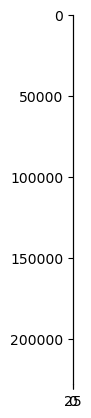

In [207]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() #One hot encoding of xs where every character index (0 to 26) is 0 except the x value which is 1
plt.imshow(xenc)


In [ ]:

W = torch.randn((27, 27), generator=g, requires_grad=True) #Fills with random numbers in normal distribution


for k in range (100):
    #Forward Pass
    logits = xenc @ W #@ is dot product (5, 27) @ (27, 27) = (5, 27) - so W*x for each example
    #Softmax------------------------------------------
    counts = logits.exp() #log-counts
    probs = counts / counts.sum(1, keepdims = True)
    #-------------------------------------------------
    probs.shape
    #Calculate loss (negative log likelihood)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() #Second part, after + sign, is regularization loss (pushes W to be 0) that penalizes complexity to prevent overfitting
    #"""
    #1D Tensor (shape 5) with values:
    #[
    #  probs[0, ys[0]], #Example 0, column ys[0]
    #  probs[1, ys[1]],
    #  probs[2, ys[2]],
    #  probs[3, ys[3]],
    #  probs[4, ys[4]]
    #]
    #"""
    print(loss.item())

    # backward pass
    W.grad = None # set gradients to 0
    loss.backward() 

    #Update weights 
    W.data += -50 * W.grad 


3.666881561279297
3.3290696144104004
3.1251285076141357
2.9936559200286865
2.9006471633911133
2.8317043781280518
2.779545307159424
2.739422082901001
2.7079288959503174
2.682635545730591
2.661858320236206
2.6444411277770996
2.629591941833496
2.616758346557617
2.605548620223999
2.5956759452819824
2.5869224071502686
2.579118013381958
2.5721261501312256
2.5658340454101562
2.560148239135742
2.554990291595459
2.5502939224243164
2.5460026264190674
2.5420682430267334
2.5384485721588135
2.535108804702759
2.5320181846618652
2.529149293899536
2.526479721069336
2.523988962173462
2.5216593742370605
2.5194754600524902
2.517423629760742
2.5154919624328613
2.5136702060699463
2.511949062347412
2.5103201866149902
2.5087761878967285
2.5073108673095703
2.50591778755188
2.504592180252075
2.503328800201416
2.5021235942840576
2.5009729862213135
2.499872922897339
2.498819589614868
2.4978110790252686
2.4968438148498535
2.4959158897399902
2.4950249195098877
2.4941675662994385
2.4933435916900635
2.49254941940307

In [209]:
#Sampling from the model:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:

    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log counts
    counts = logits.exp() # N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() #Sample from probabilities
    out.append(itos[ix])
    if ix == 0: #If '.' (ending character)
      break
  print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
